#BASIC IMPORTS

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch import optim
import cv2
from PIL import Image
from io import open
import os,string,random
from torch.utils.data import Dataset
from sklearn.preprocessing import StandardScaler,MinMaxScaler,OneHotEncoder,LabelEncoder
import pickle
from sklearn.model_selection import train_test_split
from torchsummary import summary
from IPython.display import clear_output

In [4]:
device_gpu = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#DATA PREPROCESSING

Data Augmentation
1. Image Resizing
2. Image Flipping
3. Add noise
4. Blur img
5. Normalization

In [6]:
class PlantImageDataloader(Dataset):

    def __init__(self,filename,transform,images_dict=None,labels_dict=None): 
        if (images_dict is None) or (labels_dict is None):
            self.images_dict,self.labels_dict = self.read_dataset(filename,transform)   #a dictionary containing image all the images with key=crop name
        else:
            self.images_dict = images_dict                                              #the values are of the form [image,disease] 
            self.labels_dict = labels_dict
        self.n = self.len_dict(self.images_dict)                                        #number of datapoints for each plant

        self.shuffle_indices,self.shuffle_start_index = self.get_shuffled_indices(self.n)   #indices shuffled to get a random sample
        
        
    def __len__(self,plant_name="TOMATO"):
        """Helper function to return the number of points in the specified plant"""
        return len(self.images_dict[plant_name])                        

    def len_dict(self,dictionary):
        """Function to get the dictionary containing the lengths of all the plants"""
        n={}
        for key in dictionary.keys():
            n[key] = self.__len__(key)
        return n
    
    def get_shuffled_indices(self,n):
        """Function to get the shuffled indices for random sampling for each plant"""
        shuffle_index={}
        shuffle_start_index = {}
        for key in n.keys():
            shuffle_index[key] = list(range(n[key]))
            random.shuffle(shuffle_index[key])
            shuffle_start_index[key] = 0
        return shuffle_index,shuffle_start_index

    def __getitem__(self,idx,plant_name="TOMATO"):
        """Function to return a data point of the specified plant"""
        return self.images_dict[plant_name][idx],self.labels_dict[plant_name][idx]                        
    
    def read_dataset(self,filename,img_transform):                      
        """Function to read the data"""
        dataset_dict = {}
        labels_dict = {}
        try:
            for image_folder in os.listdir(filename):                   #iterate through the different folders
                plant_name = self.getPlantName(image_folder)            #get the plant name from the function
                disease_name = self.getDiseaseName(image_folder)              #get the disease name from the filename of the img
                folders_path = f"{filename}/{image_folder}"             
                images_list = []
                labels_list=[]
                print("[INFO] Reading the folder",image_folder)         
                i=0
                for image_name in os.listdir(f"{filename}/{image_folder}"):     #iterate through the images
                    i=i+1
                    file_path = f"{filename}/{image_folder}/{image_name}"
                    current_image = Image.open(file_path)                       #read image in PIL format

                    current_image = img_transform(current_image)                #transform the image (resize,flip,tensor,normalize)

                    images_list.append(current_image)            #append the image and the disease name to a list
                    labels_list.append(disease_name)
                    if i%100==0:
                        print("Read ",i," images in ",image_folder,"folder")        
                    
                if plant_name not in dataset_dict.keys():
                    dataset_dict[plant_name] = images_list                      #add the list to the dictionary for the key=plant(crop) name
                    labels_dict[plant_name] = labels_list
                else:
                    dataset_dict[plant_name].extend(images_list)
                    labels_dict[plant_name].extend(labels_list)

        except Exception as e:
            print(f"Error : {e}")

        return dataset_dict,labels_dict
    
    def get_random_sample(self,plant_name="TOMATO"):
        """Function to get a random sample from the dataset"""
        i = np.random.randint(self.n[plant_name]) 
        return self.__getitem__(i,plant_name)
    
    def getPlantName(self,name):
        """Function for processing the file name to get the plant(crop) name"""
        plant = name[0:name.find('_')].upper()                  
        return plant
        
    def getDiseaseName(self,name):
        """Function for processing the file name to get the disease name"""
        sec_last_pos = name[:name.rfind("_")].rfind("_")        #gets the second last position of _
        tempname = name[sec_last_pos:]                          #get the disease name from the end
        disname = ""
        for sub in tempname.split('_'):                         #processing
            disname+= (sub.upper()+" ")
        disname = disname.strip()
        return disname

    def get_batch_from_array(self,batch_size,array,plant_name):
        """A helper function to get a batched input"""            
        end = (self.shuffle_start_index[plant_name]) + batch_size
        batch = []

        if end>=self.n[plant_name]:
            batch = [array[i] for i in self.shuffle_indices[plant_name][0:(end%self.n[plant_name])]]
            end = self.n[plant_name]
        return batch + [array[i] for i in self.shuffle_indices[plant_name][self.shuffle_start_index[plant_name]:end]]
    
    def get_batch(self,batch_size,plant_name="TOMATO"):
        """Fucntion to get a batched input in which the datapoints are plant data"""
           
        img_batch = self.get_batch_from_array(batch_size,self.images_dict[plant_name],plant_name)
        label_batch = self.get_batch_from_array(batch_size,self.labels_dict[plant_name],plant_name)
        self.shuffle_start_index[plant_name] += batch_size+1
        
        #Reshuffle if 1 epoch is complete
        if self.shuffle_start_index[plant_name]>=self.n[plant_name]:
            random.shuffle(self.shuffle_indices[plant_name])
            self.shuffle_start_index[plant_name] = 0

        tensor_img_batch = torch.zeros(batch_size,img_batch[0].size(0),img_batch[0].size(1),img_batch[0].size(2))
        tensor_label_batch = torch.Tensor(label_batch)
        for i,img in enumerate(img_batch):
            tensor_img_batch[i] = img

        return tensor_img_batch,tensor_label_batch          

1. The image is resize to make it fit to be an input to the resnet model
2. The data is normalized in the transforms so that all the images have the same distribution in the pixels and hence the model converges faster


In [7]:
image_transform = transforms.Compose([
                    transforms.Resize(224),
                    #transforms.RandomHorizontalFlip(p=0.6),     #can be omitted
                    transforms.ToTensor(),
                    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [ ]:
path = f"drive/My Drive/Plant Disease Identification/PlantVillage"
train_data = PlantImageDataloader(path,image_transform)

In [ ]:
image_file = open("images_dict1.pkl","wb")
label_file = open("labels_dict1.pkl","wb")
pickle.dump(train_data.images_dict,image_file)
pickle.dump(train_data.labels_dict,label_file)
image_file.close()
label_file.close()

In [8]:
path_load = f"drive/My Drive/Aditya Arnav-CropDisease/Code"
image_dict_file= open(f"{path_load}/images_dict_1.pkl","rb")
label_dict_file= open(f"{path_load}/labels_dict1.pkl","rb")
image_dict_saved = pickle.load(image_dict_file)
label_dict_saved = pickle.load(label_dict_file)

In [ ]:
#path = f"drive/My Drive/Aditya Arnav-CropDisease/Dataset/PlantVillage"
#obj_data = PlantImageDataloader(path,image_transform,image_dict_saved,label_dict_saved)

#DATA VISUALIZATION

In [ ]:
b_img,l_img = obj_data.get_batch(20,"TOMATO")

In [14]:
def print_image(img_tensor,title="default",ax=plt,axis="off"):
    img_numpy = img_tensor.numpy()                  #convert the tensor back to nummpy array
    img_numpy = img_numpy*0.5 + 0.5                 #un-normalize the array
    img_numpy = np.transpose(img_numpy,(1,2,0))     #(channels,height,width)->(height,width,channels)
    ax.imshow(img_numpy)
    if ax==plt:
        ax.title(title,fontsize=20,va='top')
    else:
        ax.set_title(title,fontsize=5,va='top')
    ax.axis(axis)

def show_batch_img(images,labels,num_cols=4):
    n = len(images)                             #get the total number images
    num_rows = np.ceil(n/num_cols)              #get the number of rows based on the number of images in 1 row
    fig = plt.figure(figsize=(num_cols,num_rows),dpi=200)   #get a figure handler for the plot figure

    for i in range(n):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)        #add the figures 
        print_image(images[i],labels[i],ax=ax1)             #print the figures
    

In [ ]:
show_batch_img(b_img,l_img)

In [ ]:
a,b = train_data.get_batch(5,"PEPPER")

In [ ]:
a,b = obj_data.get_batch(6,"PEPPER")
show_batch_img(a,b)

In [ ]:
a,b = obj_data.get_batch(10,"TOMATO")
show_batch_img(a,b)

#TRAINING

Test Train Split and Label Encodings

In [15]:
X_train,X_val,Y_train,Y_val = train_test_split(image_dict_saved["TOMATO"],
                                               label_dict_saved["TOMATO"],
                                               test_size=0.15,
                                               stratify=label_dict_saved["TOMATO"],
                                               random_state=0)
#enc = OneHotEncoder()
le = LabelEncoder()
Y_L_train = le.fit_transform(Y_train)           #labels encoding to be used for the cross entropy loss function
Y_L_val = le.fit_transform(Y_val)
#Y_OH_train = enc.fit_transform(np.expand_dims(Y_train,1)).toarray()
#Y_OH_val = (enc.fit_transform(np.expand_dims(Y_val,1))).toarray()

METHOD-1

In [16]:
train_img_dict = {}
val_img_dict={}
train_label_dict={}
val_label_dict={}
train_img_dict["TOMATO"] = X_train
val_img_dict["TOMATO"] = X_val
train_label_dict["TOMATO"] = Y_L_train
val_label_dict["TOMATO"] = Y_L_val

path = f"drive/My Drive/Aditya Arnav-CropDisease/Dataset/PlantVillage"
train_data = PlantImageDataloader(path,image_transform,train_img_dict,train_label_dict)
val_data = PlantImageDataloader(path,image_transform,val_img_dict,val_label_dict)

In [17]:
def train_batch(net,opt,criterion,data,batch_size=128,epochs=1000,plant_name="TOMATO",display=True,device='cpu'):
    
    loss_arr=[]
    for i in range(epochs):
        net.train().to(device)
        opt.zero_grad()
        img_batch,label_batch = data.get_batch(batch_size,plant_name)
        img_batch,label_batch = img_batch.to(device),label_batch.to(device)    

        output = net(img_batch)
        loss = criterion(output,label_batch.long())

        loss.backward()
        opt.step()

        loss_arr.append(loss)
        if display and (i%10==0):

            clear_output(wait=True)
            print('Iteration',i,'Loss',loss_arr[i])
            plt.figure()
            plt.plot(loss_arr[0:i],'-*')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.show()
            print('\n\n')
    
    return loss_arr

METHOD-2

In [28]:
batch_size = 128
traindata = []
for i in range(len(X_train)):
    elt = [X_train[i],Y_L_train[i]]
    traindata.append(elt)

valdata = []
for i in range(len(X_val)):
    elt = [X_val[i],Y_L_val[i]]
    valdata.append(elt)

trainloader = torch.utils.data.DataLoader(traindata,shuffle=True,batch_size=batch_size)
valloader = torch.utils.data.DataLoader(valdata,shuffle=True,batch_size=batch_size)

In [19]:
dataiter = iter(trainloader)
img,lab = next(dataiter)

In [20]:
def train_batch2(net,opt,criterion,dataloader,epochs=1000,display=True,device='cpu'):
    
    loss_arr=[]
    net.train().to(device)
    for j in range(epochs):
        for i,data in enumerate(dataloader):
        
            
            opt.zero_grad()

            inputs,labels = data
            inputs,labels = inputs.to(device),labels.to(device)

            outputs = net(inputs)
            loss = criterion(outputs,labels.long())

            loss.backward()
            opt.step()

            loss_arr.append(loss)
            if display and (i%10==0):

                clear_output(wait=True)
                print('Iteration',i,'Loss',loss_arr[i])
                plt.figure()
                plt.plot(loss_arr[0:i],'-*')
                plt.xlabel('Iteration')
                plt.ylabel('Loss')
                plt.show()
                print('\n\n')
    
    return loss_arr

#RESNET 50 MODEL

RESNET CASE-1

In [21]:
resnet_1 = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [22]:
print(resnet_1)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [23]:
"""Freeze all the layers of the resnet"""
for param in resnet_1.parameters():
    param.requires_grad_(False)

Referring to the above resnet50 structure we will unfreeze some parts of the third bottleneck of the layer4. We will also change the fully connected layer in the end to match the number of labels availabe for our disease.
 

In [24]:
"""Unfreezing the conv3,bn3 adn relu layer of the third bottleneck of the layer4"""
count = 0
for param in resnet_1.layer4[2].parameters():
    if count>=6:
        param.requires_grad_(True)
    count+=1

In [25]:
new_out_features = 10           #total number of dieseas for tomato in our dataset. Here we have 10 diseases in total
final_in_features = resnet_1.fc.in_features
resnet_1.fc = nn.Sequential(
                 nn.Linear(final_in_features,new_out_features),
                 nn.Softmax())
#resnet_1.fc = nn.Linear(final_in_features,new_out_features)

In [26]:
summary(resnet_1, (3,224,224),device="cpu")         #trainable parameters are 10,73,162

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Iteration 990 Loss tensor(1.4818, device='cuda:0', grad_fn=<NllLossBackward>)


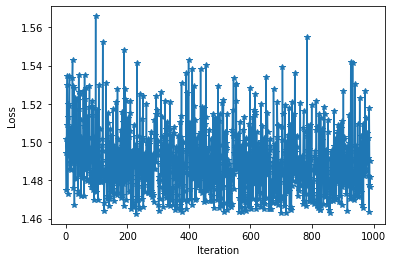

In [130]:
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(resnet_1.parameters(),lr=0.0001)
resnet_1_loss_arr = train_batch(resnet_1,opt,criterion,train_data,batch_size=64,epochs=1000,display=True,device=device_gpu)

In [129]:
calc_accuracy(resnet_1,val_data,128,device_gpu)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0.9254364852206495

In [138]:
torch.save(resnet_1,"resnet_1.1")

In [ ]:
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(resnet_1.parameters(),lr=0.01)
resnet_1_loss_arr = train_batch2(resnet_1,opt,criterion,trainloader,epochs=1000,display=True,device=device_gpu)

In [ ]:
img,label = train_data.get_batch(1,"TOMATO")
img = img.to(device_gpu)
#resnet_1(img)
max_val,pred_label = torch.max(resnet_1(img),1)
pred_label = le.inverse_transform(pred_label.to("cpu").numpy())
print(le.inverse_transform(np.array(label,dtype=np.int)))
print("\n")
print(pred_label)

['CURL VIRUS']


['CURL VIRUS']


RESNET 2

In [131]:
resnet_2 = models.resnet50(pretrained=True)

In [132]:
"""Freeze all the layers of the resnet"""
for param in resnet_2.parameters():
    param.requires_grad_(False)

In [133]:
"""Unfreezing the conv3,bn3 adn relu layer of the third bottleneck of the layer4"""
count = 0
for param in resnet_2.layer4[2].parameters():
    if count>=3:
        param.requires_grad_(True)
    count+=1

In [134]:
new_out_features = 10           #total number of dieseas for tomato in our dataset. Here we have 10 diseases in total
final_in_features = resnet_2.fc.in_features
resnet_2.fc = nn.Linear(final_in_features,new_out_features)

In [135]:
summary(resnet_2, (3, 224, 224),device="cpu")       #Trainable parameters are 34,33,482

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

Iteration 990 Loss tensor(0.0090, device='cuda:0', grad_fn=<NllLossBackward>)


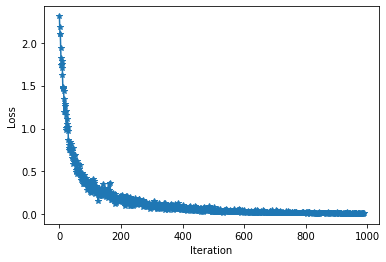

In [136]:
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(resnet_2.parameters(),lr=0.0001)
resnet_2_loss_arr = train_batch(resnet_2,opt,criterion,train_data,device=device_gpu)

In [137]:
calc_accuracy(resnet_2,val_data,128,device_gpu)

0.9750078059950041

In [139]:
torch.save(resnet_2,"resnet_2.1")

In [141]:
img,label = train_data.get_batch(1,"TOMATO")
img = img.to(device_gpu)
max_val,pred_label = torch.max(resnet_2(img),1)
pred_label = le.inverse_transform(pred_label.to("cpu").numpy())
print(le.inverse_transform(np.array(label,dtype=np.int)))
print("\n")
print(pred_label)

['HEALTHY']


['HEALTHY']


In [ ]:
img,label = train_data.get_batch(1,"TOMATO")
img = img.to(device_gpu)
resnet_2(img)

MODEL ACCURACIES

In [104]:
def infer(net,inputs,le=None,original=False,device="cpu"):
    net.to(device)
    pred_outputs = net(inputs)

    pred_output_labels = torch.argmax(pred_outputs,1)
    # if original:
    #     pred_output_labels = le.inverse_transform(pred_output_labels.to("cpu").numpy())
    
    return [pred_output_labels[i].item() for i in range(len(pred_output_labels))]

In [121]:
def calc_accuracy(net,test_data,batch_size=128,device='cpu'):
    net = net.eval().to(device)
    predictions = []
    accuracy = 0
    for i in range(test_data.n["TOMATO"]):
        images,labels = test_data.get_batch(batch_size)
        images,labels = images.to(device), labels.to(device)
        outputs = infer(net,images,device=device)
        correct = 0
        for index,out in enumerate(outputs):
            if out == labels[index]:
                correct+=1

        accuracy+=correct/len(outputs)

    accuracy/=len(test_data)
    return accuracy

In [ ]:
# def calc_accuracy2(net,test_data,batch_size=128,device='cpu'):
#     net = net.eval().to(device)
#     predictions = []
#     accuracy = 0
#     for i in range(len(test_data)):
#         #images,labels = test_data[i]
#         images = torch.unsqueeze(images,0)
#         #images,labels = test_data.get_batch(128)
#         outputs = infer(net,images)
#         correct = 0
#         for index,out in enumerate(outputs):
#             if out == labels:
#                 correct+=1

#         accuracy+=correct/len(outputs)

#     accuracy/=len(test_data)
#     return accuracy

In [ ]:
# def calc_accuracy(net,data,check_points=1000,plant_name="TOMATO",device='cpu'):
#     net = net.eval().to(device)

#     predictions = []
#     accuracy = 0
#     correct=0
    

#     for i in range(check_points):

#         image,label = data.get_random_sample(plant_name)
#         image.to(device)
#         pred_label = out
#         outputs = infer(net,eng,gt.shape[0],device)
#         correct = 0
#         for index,out in enumerate(outputs):
#             val,indices = out.topk(1)
#             hindi_pos = indices.tolist()[0]
#             if hindi_pos[0] == gt[index][0]:
#                 correct+=1
#         accuracy+=correct/gt.shape[0]
#     accuracy/=len(train_data)
#     return accuracy